# Solving inverse problems on GPUs with Pylops+CuPy - Seismic interpolation

Welcome to the tutorial of this session! In this tutorial we will consider the problem of reconstructing missing traces in seismic data, also known as **Seismic interpolation**

By the end of the tutorial you will have learned:
- how to use more advanced PyLops operators.
- how to precondition inverse problems in PyLops
- how to easily switch between CPU-based to GPU-based inversion;


## Create environment with PyLops+CuPy+CuSignal

In [1]:
!git clone https://github.com/PyLops/pylops_swungrendezvous2021.git

fatal: destination path 'pylops_swungrendezvous2021' already exists and is not an empty directory.


In [2]:
!chmod u+x pylops_swungrendezvous2021/install.sh
!pylops_swungrendezvous2021/install.sh

--2021-02-05 17:02:21--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2021-02-05 17:02:22--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh.4’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   212MB/s    in 0.3s    

2021-02-05 17:02:22 (212 MB/s) - ‘Miniconda3-4.5.4-Linux-x8

In [3]:
!pip install git+https://github.com/PyLops/pylops.git

  Cloning https://github.com/PyLops/pylops.git to /tmp/pip-req-build-jbj9rzq3


In [4]:
import os,sys
_ = (sys.path.append("/usr/local/lib/python3.6/site-packages"))
os.chdir('pylops_swungrendezvous2021')

## Example: Seismic Interpolation


The problem of *seismic data regularization* (or interpolation) is a very simple one to write, yet ill-posed and very hard to solve.

The forward modelling operator is a simple `pylops.Restriction`
operator which extracts a set of traces along the spatial direction(s).

$$
\mathbf{y} = \mathbf{R} \mathbf{x}
$$

Here $\mathbf{y} = [\mathbf{y}_{R1}^T, \mathbf{y}_{R2}^T,...,
\mathbf{y}_{RN}^T]^T$ where each vector $\mathbf{y}_{Ri}$
contains all time samples recorded in the seismic data at the specific receiver $R_i$. Similarly, $\mathbf{x} = [\mathbf{x}_{r1}^T, \mathbf{x}_{r2}^T,..., \mathbf{x}_{rM}^T]$, contains all traces at the regularly and finely sampled receiver locations $`r_i$.

By inverting such an equation we can create a regularized data with densely and regularly spatial direction(s).

A variety of (more or less succesfull) methods have been proposed over the years to fill missing traces in seismic data. One class of methods recast this problem as a *sparsity-promoting optimization* where a solution with a small set of non-zero coefficients (aka sparse model estimate) is sought in a transformed domain. Again, various transforms have been succesfully applied to seismic data; in this tutorial we consider:
- `Linear Radon` transform in sliding windows
- `FK` transform in patches

Another popular transform is the `Curvelet` transform. A Python wrapper of the original [CurveLap](http://www.curvelet.org) C++ implementation is provided in [CurveLops](https://github.com/PyLops/curvelops) which allows direct integration with PyLops. Note however that this code can only run on CPU.

 Let's start now by importing all useful libraries

In [5]:
%matplotlib inline
import time
import os
import numpy as np
import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.signal import convolve
from pylops.utils import dottest
from pylops.basicoperators import Restriction
from pylops.signalprocessing import FFT2D, ChirpRadon2D, Sliding2D, Patch2D
from pylops.waveeqprocessing.seismicinterpolation import SeismicInterpolation
from pylops.optimization.sparsity import FISTA
from invwidget import inversion_widget

plt.style.use('seaborn-dark')
print('cp.__version__:',  cp.__version__)

np.random.seed(10)

cp.__version__: 8.1.0


We can now load our input data

In [6]:
inputfile = 'data.npz'
inputdata = np.load(inputfile, allow_pickle=True)

# Load data, time and space axes
x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
nx, nt = x.shape
dx = inputdata['r'][0, 1] - inputdata['r'][0, 0]
dt = inputdata['t'][1] - inputdata['t'][0]

# Convolve data with wavelet
wav = inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :nt]

# Apply gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, nx)).T
x *= gain

We can now define our subsampling operator and display both the original and decimated data

Dot test passed, v^T(Opu)=11.242378 - u^T(Op^Tv)=11.242378


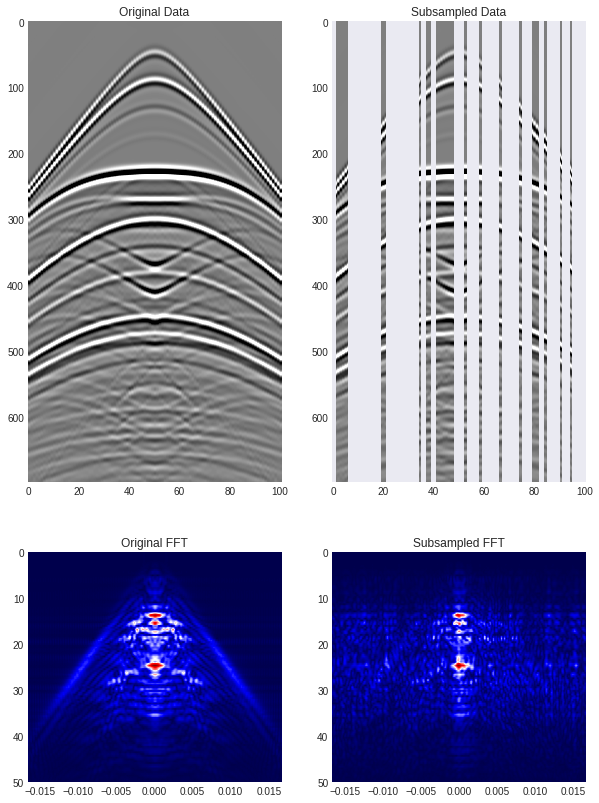

In [7]:
# Define subsampling locations
perc_subsampling = 0.5
nxsub = int(np.round(nx * perc_subsampling))
ixava = np.sort(np.random.permutation(np.arange(nx))[:nxsub])

# Create restriction operator
Rop = Restriction(nx * nt, ixava, dims=(nx, nt), dir=0, dtype=np.float64)
dottest(Rop, nxsub * nt, nx * nt, verb=True)

# Create data
y = Rop * x.ravel()
xadj = Rop.H * y.ravel()
y = y.reshape(nxsub, nt)
xadj = xadj.reshape(nx, nt)

# Apply mask
ymask = Rop.mask(x.ravel())

# FFT of full data
nfft = 2**10
FFTop = FFT2D(dims=(nx, nt), nffts=(nfft, nfft), sampling=(dx, dt))
p = FFTop * x.ravel()
p = np.reshape(p, (nfft, nfft))

pmask = FFTop * ymask.flatten()
pmask = np.reshape(pmask, (nfft, nfft))


fig, axs = plt.subplots(2, 2, figsize=(10, 14),
                        gridspec_kw={'height_ratios': [2, 1]})
axs[0][0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0][0].set_title('Original Data')
axs[0][0].axis('tight')
axs[0][1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0][1].set_title('Subsampled Data')
axs[0][1].axis('tight')
axs[1][0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]), axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], 
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1][0].set_title('Original FFT')
axs[1][0].axis('tight')
axs[1][0].set_ylim(50, 0)
axs[1][1].imshow(np.fft.fftshift(np.abs(pmask[:, :nfft//2-1]), axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0],
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1][1].set_title('Subsampled FFT')
axs[1][1].axis('tight')
axs[1][1].set_ylim(50, 0);

### Sliding Linear Radon

Our first example uses a Sliding Linear Radon as sparsifying transform. This is created by combining the `pylops.signalprocessing.ChirpRadon2D` and `pylops.signalprocessing.Sliding2D` operators.

Finally we use our high-level app `pylops.waveeqprocessing.seismicinterpolation.SeismicInterpolation` to setup and run the inversion. This app has been created such that the user needs to simply provide the decimated data and information regarding the indeces of available traces alongside additional parameters to choose the sparsifying transform and the solver to be used.

Dot test passed, v^T(Opu)=-2826.117172 - u^T(Op^Tv)=-2826.117172
Dot test passed, v^T(Opu)=-535.569114 - u^T(Op^Tv)=-535.569114
FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 35000 rows and 126000 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 400
alpha = 1.200000e-03	thresh = 3.000000e-06
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -0.00000e+00   8.727e+00   8.746e+00   2.303e-02
     2  -0.00000e+00   8.307e+00   8.346e+00   2.234e-02
     3  -0.00000e+00   7.803e+00   7.865e+00   2.779e-02
     4  -0.00000e+00   7.235e+00   7.325e+00   3.258e-02
     5  -0.00000e+00   6.626e+00   6.747e+00   3.673e-02
     6  -0.00000e+00   5.994e+00   6.150e+00   4.025e-02
     7  -0.00000e+00   5.359e+00   5.551e+00   4.314e-02
     8  -0.00000e+00   4.736e+00   4.966e+00   4.542e-02
     9  -0.00000e+00   4.138e+00   4.408e+00   4.710e-02
   

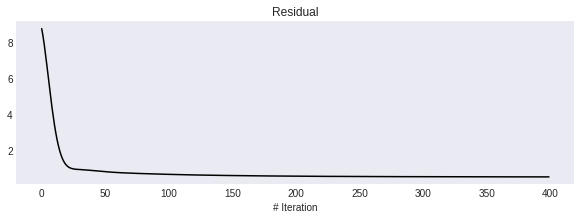

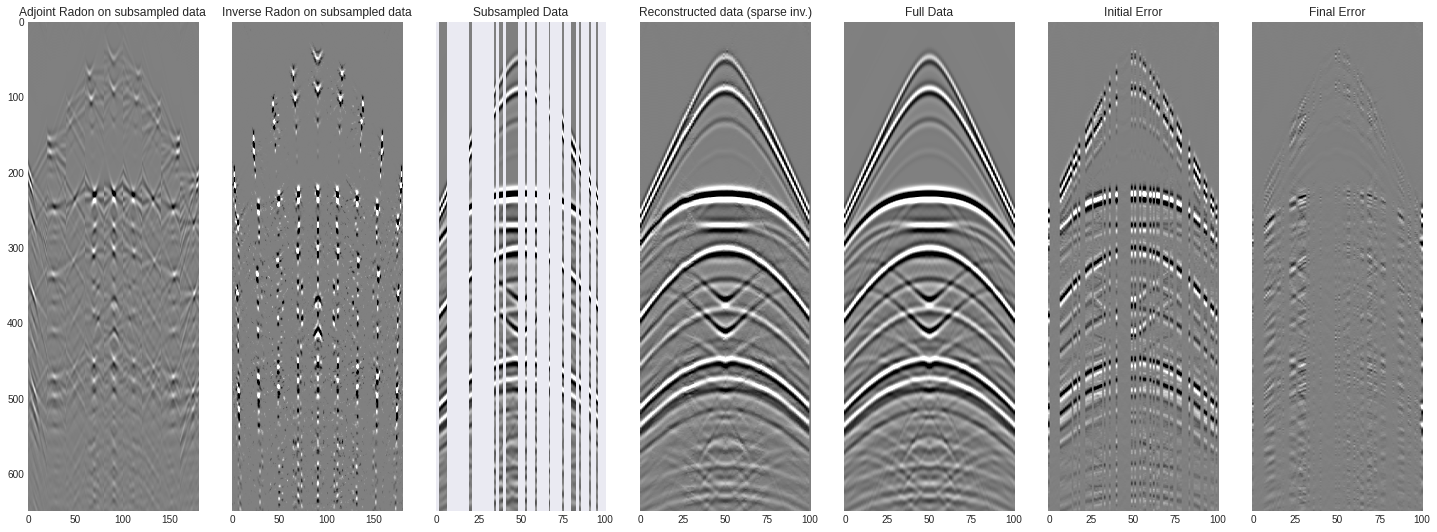

In [8]:
# Sliding Radon operator
nwin = 20 # Size of slice in spatial direction
nwins = 9 # Number of slices
nover = 10 # Number of overlapping samples between windows
pxmax = 5e-4 # Max slowness

px = np.linspace(-pxmax, pxmax, nwin)
dimsd = x.shape
dims = (nwins*nwin, dimsd[1])
Op = ChirpRadon2D(taxis, np.linspace(-dx*nwin//2, dx*nwin//2, nwin), pxmax * dx / dt).H
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine', design=False)
dottest(Slidop, np.prod(dimsd), np.prod(dims), verb=True)

# Adjoint
Rop1 = Rop * Slidop

padj = Rop1.H * y.flatten()
padj = padj.reshape(nwin*nwins, nt)

# Inverse
def callback(x, xhistory, Pop, xshape, xtrue=None, xerror=None):
    x = cp.asnumpy(np.real(Pop * x).reshape(xshape).T)
    xhistory.append(x)
    if xtrue is not None:
        xerror.append(np.linalg.norm(x-xtrue))

xhist = []
xerror = []
xinv, pinv, cost = SeismicInterpolation(cp.asarray(y), nx, ixava, kind='sliding', spataxis=xaxis, 
                                        taxis=taxis, paxis=px, nwins=nwins, nwin=nwin, 
                                        nover=nover, dottest=True,
                                        **dict(niter=400, eps=5e-3, alpha=1.2e-3, 
                                               returninfo=True, show=True,
                                               callback=lambda xinv: callback(xinv, xhist, Slidop, 
                                                                              (nx, nt), x.T, xerror)))

# Visualize results
plt.figure(figsize=(10, 3))
plt.plot(cost, 'k')
plt.xlabel('# Iteration')
plt.title('Residual')

fig, axs = plt.subplots(1, 7, sharey=True, figsize=(25, 9))
axs[0].imshow(padj.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[0].set_title('Adjoint Radon on subsampled data')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(pinv).T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[1].set_title('Inverse Radon on subsampled data')
axs[1].axis('tight')
axs[2].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Subsampled Data')
axs[2].axis('tight');
axs[3].imshow(cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Full Data')
axs[4].axis('tight')
axs[5].imshow(ymask.data.T - cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Initial Error')
axs[5].axis('tight');
axs[6].imshow(x.T - cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[6].set_title('Final Error')
axs[6].axis('tight')
axs[6].set_ylim(650, 0);

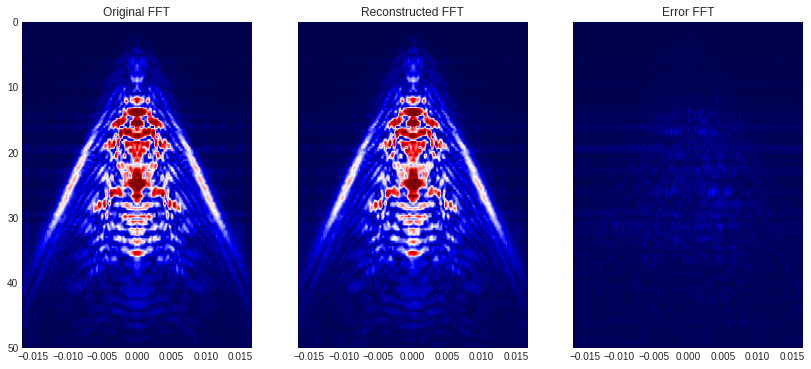

In [9]:
# FFT of full and reconstructed data
pinv = FFTop * cp.asnumpy(xinv).flatten()
pinv = np.reshape(pinv, (nfft, nfft))

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]), axes=0).T, 
              cmap='seismic', vmax=0.05,
              extent=(np.fft.fftshift(FFTop.f1)[0], 
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
axs[1].imshow(np.fft.fftshift(np.abs(pinv[:, :nfft//2-1]), axes=0).T, 
              cmap='seismic', vmax=0.05,
              extent=(np.fft.fftshift(FFTop.f1)[0],
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[2].imshow(np.fft.fftshift(np.abs((p-pinv)[:, :nfft//2-1]), axes=0).T, 
              cmap='seismic', vmax=0.05,
              extent=(np.fft.fftshift(FFTop.f1)[0],
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[2].set_title('Error FFT')
axs[2].axis('tight')
axs[2].set_ylim(50, 0);

In [10]:
inversion_widget(ymask.T, xhist, cost, error=np.array(xerror), model_true=x.T, 
                 title='Reconstruction Widget', vmin=-0.05, vmax=0.05)

Output()

Finally we compare the speed of our inversion on CPU and GPU

In [11]:
# Numpy
xinv, pinv, cost = SeismicInterpolation(y, nx, ixava, kind='sliding', spataxis=xaxis, 
                                        taxis=taxis, paxis=px, nwins=nwins, nwin=nwin, 
                                        nover=nover, dottest=False,
                                        **dict(niter=100, eps=5e-3, alpha=1.2e-3, 
                                                returninfo=True, show=True))

# Cupy
xinv, pinv, cost = SeismicInterpolation(cp.asarray(y), nx, ixava, kind='sliding', spataxis=xaxis, 
                                        taxis=taxis, paxis=px, nwins=nwins, nwin=nwin, 
                                        nover=nover, dottest=False,
                                        **dict(niter=100, eps=5e-3, alpha=1.2e-3, 
                                                returninfo=True, show=True))

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 35000 rows and 126000 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 1.200000e-03	thresh = 3.000000e-06
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   8.760e+00   8.779e+00   2.213e-02
     2   0.00000e+00   8.369e+00   8.407e+00   2.153e-02
     3   0.00000e+00   7.898e+00   7.958e+00   2.684e-02
     4   0.00000e+00   7.363e+00   7.451e+00   3.156e-02
     5   0.00000e+00   6.786e+00   6.904e+00   3.569e-02
     6   0.00000e+00   6.183e+00   6.334e+00   3.925e-02
     7   0.00000e+00   5.570e+00   5.758e+00   4.224e-02
     8   0.00000e+00   4.964e+00   5.189e+00   4.465e-02
     9   0.00000e+00   4.376e+00   4.641e+00   4.651e-02
    10   0.00000e+00   3.817e+00   4.122e+00   4.783e-02
    11   0.00000e+00   3.294e+00   3.641e+00   4.864e-02
    21   0.00000e

### FK Patches

Let's now move on to using the FK tranform as our sparsifying operator in small overlapping windows.



In [15]:
dimsd = x.shape
nwin = (20, 34)
nover = (10, 5)
nop = (128, 128)
nwins = (9, 23)
dims = (nwins[0]*nop[0], nwins[1]*nop[1])

Fop = FFT2D(nwin, nffts=nop)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop,
              tapertype='hanning', # 'cosine'
              design=True)
dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, tol=1e-2, verb=True)

# Invert operator
p1 = Sop.div(x.ravel(), 50)
pmask = Sop.div(ymask.ravel(), 50)

 1792 1920 2048 2176 2304 2432 2560 2688 2816], end:[ 128  256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792
 1920 2048 2176 2304 2432 2560 2688 2816 2944]
 522 551 580 609 638], end:[ 34  63  92 121 150 179 208 237 266 295 324 353 382 411 440 469 498 527
 556 585 614 643 672]


Dot test passed, v^T(Opu)=-280.011722-519.667824i - u^T(Op^Tv)=-280.011722-519.667824i


In this case, we cannot use our high-level app like we did before as FK patching is not yet been included there.

It is however very easy to just solve the problem by passing the operator and data to our solver `pylops.optimization.sparsity.FISTA`. Note that in this case we will use a decaying regularization damping factor so that the more iterations progress the more we will try to bring in details.

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 35000 rows and 3391488 cols
eps = 4.000000e-03	tol = 1.000000e-10	niter = 200
alpha = 2.500000e-01	thresh = 5.000000e-04
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -0.00000e+00   6.751e+00   7.699e+00   7.355e-01
     2  -0.00000e+00   5.104e+00   6.810e+00   5.959e-01
     3  -0.00000e+00   3.674e+00   6.156e+00   6.235e-01
     4  -0.00000e+00   2.572e+00   5.775e+00   5.999e-01
     5  -0.00000e+00   1.791e+00   5.617e+00   5.442e-01
     6  -0.00000e+00   1.271e+00   5.598e+00   4.737e-01
     7  -0.00000e+00   9.373e-01   5.640e+00   4.023e-01
     8  -0.00000e+00   7.251e-01   5.691e+00   3.397e-01
     9  -0.00000e+00   5.894e-01   5.725e+00   2.903e-01
    10  -0.00000e+00   5.008e-01   5.734e+00   2.543e-01
    11  -0.00000e+00   4.415e-01   5.720e+00   2.297e-01
    21  -0.00000

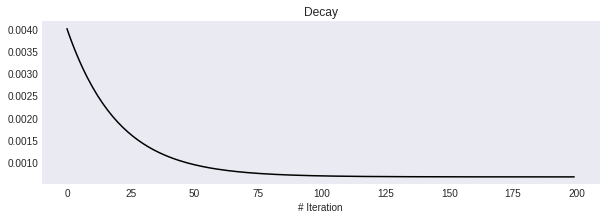

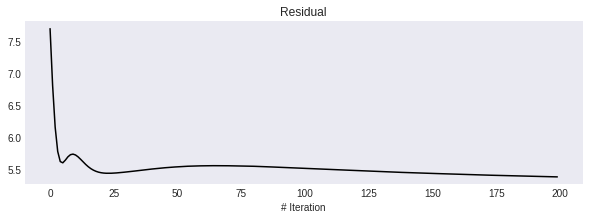

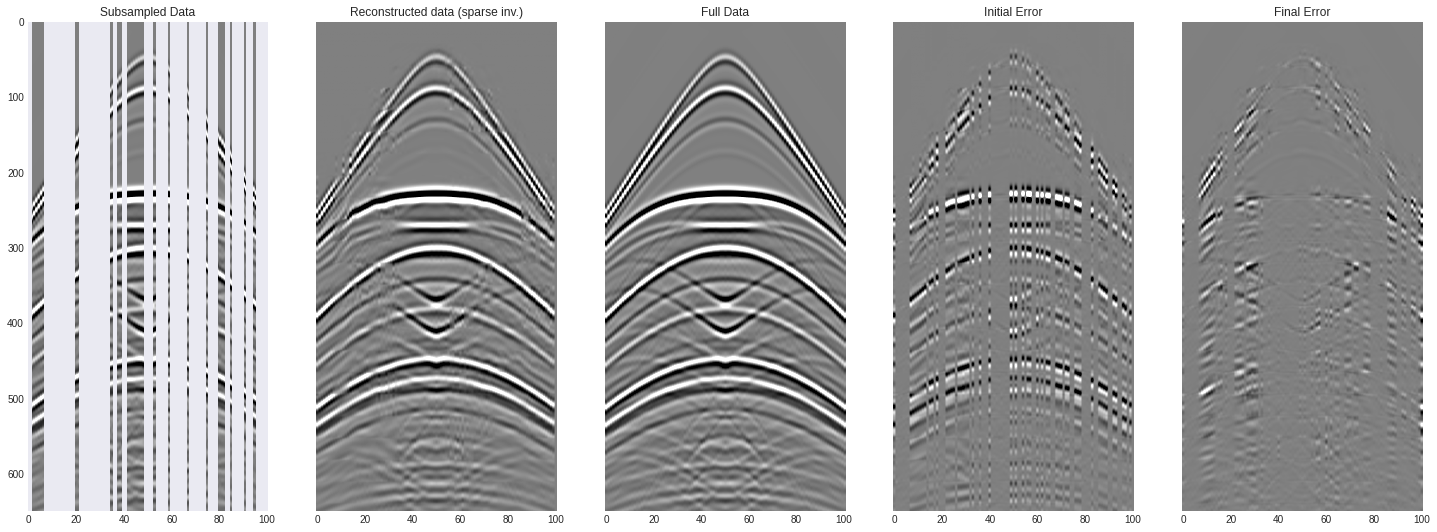

In [13]:
# Solver parameters 
eps = 4e-3
niter = 200
decay = (np.exp(-0.05*np.arange(niter)) + 0.2) / 1.2

xhist = []
xerror = []
Rop1 = Rop * Sop
pinv, _, cost = FISTA(Rop1, cp.asarray(y).ravel(), niter=niter, eps=eps, alpha=2.5e-1, #eigsiter=10, eigstol=1e-1, 
                      decay=decay, tol=1e-10, returninfo=True, show=True,
                      callback=lambda xinv: callback(xinv, xhist, Sop, (nx, nt), x.T, xerror))

xinv = cp.real(Sop * pinv)
pinv = cp.asnumpy(pinv)
xinv = cp.asnumpy(xinv.reshape(nx, nt))

# Visualize results
plt.figure(figsize=(10, 3))
plt.plot(eps*decay, 'k')
plt.xlabel('# Iteration')
plt.title('Decay')

plt.figure(figsize=(10, 3))
plt.plot(cost, 'k')
plt.xlabel('# Iteration')
plt.title('Residual')

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(25, 9))
axs[0].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Subsampled Data')
axs[0].axis('tight');
axs[1].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Reconstructed data (sparse inv.)')
axs[1].axis('tight')
axs[2].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Full Data')
axs[2].axis('tight')
axs[3].imshow(ymask.data.T - cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Initial Error')
axs[3].axis('tight');
axs[4].imshow(x.T - cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Final Error')
axs[4].axis('tight')
axs[4].set_ylim(650, 0);

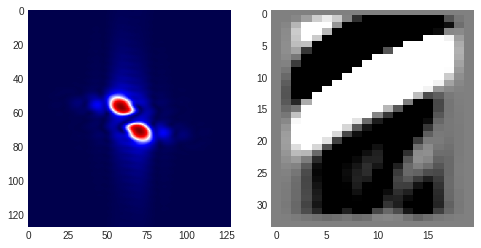

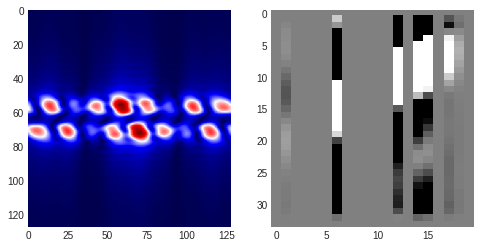

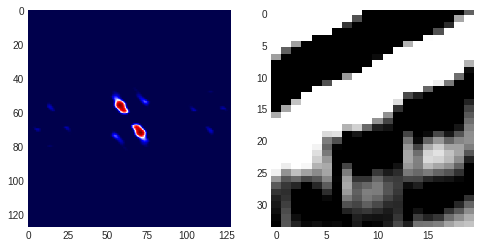

In [16]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 2*nwins[1] + 8
#ipatch = 4*23 + 8

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p1[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)), cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p1[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.01, vmax=0.01)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)), cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.01, vmax=0.01)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(pinv[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)), cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * pinv[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.01, vmax=0.01)
axs[1].axis('tight');

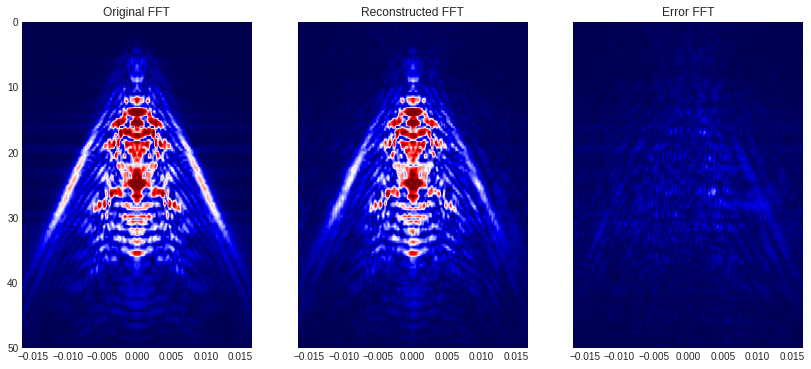

In [17]:
# FFT of full and reconstructed data
pinv = FFTop * cp.asnumpy(xinv).flatten()
pinv = np.reshape(pinv, (nfft, nfft))

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]), axes=0).T, 
              cmap='seismic', vmax=0.05,
              extent=(np.fft.fftshift(FFTop.f1)[0], 
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
axs[1].imshow(np.fft.fftshift(np.abs(pinv[:, :nfft//2-1]), axes=0).T, 
              cmap='seismic', vmax=0.05,
              extent=(np.fft.fftshift(FFTop.f1)[0],
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[2].imshow(np.fft.fftshift(np.abs((p-pinv)[:, :nfft//2-1]), axes=0).T, 
              cmap='seismic', vmax=0.05,
              extent=(np.fft.fftshift(FFTop.f1)[0],
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[2].set_title('Error FFT')
axs[2].axis('tight')
axs[2].set_ylim(50, 0);

In [18]:
# Numpy
Rop = Restriction(nx * nt, ixava, dims=(nx, nt), dir=0, dtype=np.float64)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop,
              tapertype='hanning')
Rop1 = Rop * Sop
xinv = FISTA(Rop1, y.ravel(), niter=10, eps=eps, alpha=2.5e-1, #eigsiter=10, eigstol=1e-1, 
          decay=decay, tol=1e-10, returninfo=True, show=True)[0]

# Cupy
Rop = Restriction(nx * nt, ixava, dims=(nx, nt), dir=0, dtype=np.float64)
Rop1 = Rop * Sop
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop,
              tapertype='hanning')
xinvc = FISTA(Rop1, cp.asarray(y.ravel()), niter=10, eps=eps, alpha=2.5e-1, #eigsiter=10, eigstol=1e-1, 
      decay=decay, tol=1e-10, returninfo=True, show=True)[0]

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 35000 rows and 3391488 cols
eps = 4.000000e-03	tol = 1.000000e-10	niter = 10
alpha = 2.500000e-01	thresh = 5.000000e-04
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -0.00000e+00   6.751e+00   7.699e+00   7.355e-01
     2  -0.00000e+00   5.104e+00   6.810e+00   5.959e-01
     3  -0.00000e+00   3.674e+00   6.156e+00   6.235e-01
     4  -0.00000e+00   2.572e+00   5.775e+00   5.999e-01
     5  -0.00000e+00   1.791e+00   5.617e+00   5.442e-01
     6  -0.00000e+00   1.271e+00   5.598e+00   4.737e-01
     7  -0.00000e+00   9.373e-01   5.640e+00   4.023e-01
     8  -0.00000e+00   7.251e-01   5.691e+00   3.397e-01
     9  -0.00000e+00   5.894e-01   5.725e+00   2.903e-01
    10  -0.00000e+00   5.008e-01   5.734e+00   2.543e-01

Iterations = 10        Total time (s) = 8.63
----------------------------